In [2]:
import pandas as pd
import tarfile      #to extract json's out of yelp_dataset.tar
import numpy as np
import json
from nltk.corpus import wordnet
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.metrics.pairwise import linear_kernel
import string
import gensim
from nltk.stem import WordNetLemmatizer
import nltk
import os
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import folium

stop_words = nltk.corpus.stopwords.words('english')

## Initial Data Extraction

The data came as a tar file consisting of 5 jason files. We pickled the 2 we decided to use for sharing and working with. 

In [2]:
# # extract json's out of yelp dataset
# yelp_tar = tarfile.open('yelp_dataset.tar')
# yelp_tar.extractall('./yelp')
# yelp_tar.close()
# yelp_business_df = pd.read_json('./yelp/yelp_academic_dataset_business.json',
#                                lines=True)
# yelp_business_df.to_pickle('./business.pkl')

In [3]:
yelp_business_df = pd.read_pickle("./business.pkl")
yelp_business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'..."
1,tCbdrRPZA0oiIYSmHG3J0w,Flying Elephants at PDX,7000 NE Airport Way,Portland,OR,97218,45.588906,-122.593331,4.0,126,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsAtt...","Salad, Soup, Sandwiches, Delis, Restaurants, C...","{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ..."
2,bvN78flM8NLprQ1a1y5dRg,The Reclaimory,4720 Hawthorne Ave,Portland,OR,97214,45.511907,-122.613693,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Antiques, Fashion, Used, Vintage & Consignment...","{'Thursday': '11:0-18:0', 'Friday': '11:0-18:0..."
3,oaepsyvc0J17qwi8cfrOWg,Great Clips,2566 Enterprise Rd,Orange City,FL,32763,28.914482,-81.295979,3.0,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Beauty & Spas, Hair Salons",None
4,PE9uqAjdw0E4-8mjGl3wVA,Crossfit Terminus,1046 Memorial Dr SE,Atlanta,GA,30316,33.747027,-84.353424,4.0,14,1,"{'GoodForKids': 'False', 'BusinessParking': '{...","Gyms, Active Life, Interval Training Gyms, Fit...","{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'..."


### Applying the same code to the Reviews data gave us a MemoryError

So we had to filter the data before we could work with it. 

In [4]:
# # Reviews data set was too big to pd.read_json so we needed to filter

# $ sudo apt-get install jq
# # filter only 2018 reviews
# ! cat yelp_academic_dataset_review.json | jq -c \
# 'select( .date | contains("2018"))' > 2018_reviews.json
# # now a size we can read the lines
# file = open("2018_reviews.txt","r")
# line = file.readlines()
# file.close()
# # and convert to json
# with open('2018_reviews_to.json','w') as fout:
#     json.dump(line, fout)
# read the new json file
# reviews2 = pd.read_json('./2018_reviews.json',lines=True)
# reviews2.head()
# # remove un-needed columns
# review_df = reviews2[['business_id','stars','text']]
# review_df
# review_df.to_pickle('./review_df.pkl')

In [4]:
review_df = pd.read_pickle("./review_df.pkl")
review_df.head()

,business_id,stars,text
0,xGXzsc-hzam-VArK6eTvtw,1,"This place used to be a cool, chill place. Now..."
1,KXCXaF5qimmtKKqnPc_LQA,1,Great coffee and pastries. Baristas are excell...
2,vRrDTIW9IFBO4cc3laazUw,5,So sad to learn they are demolishing this. Alw...
3,VPqWLp9kMiZEbctCebIZUA,3,"Overall is good, is worth the line up I don't ..."
4,9P-lp3AWDXGayDqJz9VPwQ,2,The ramen here is less than great. It came out...


## Using yelp_business_df 'categories', we narrowed down to only bar related businesses

First we need to get an idea of how many categories we're dealing with.

In [5]:
# Create category list
unique_categories = set()
for c in yelp_business_df['categories']:
    if c != None:
        track = c
        temp = c.replace(',','').split()
        for t in temp:
            unique_categories.add(t.lower())
len(unique_categories)            

1410

In [6]:
# yelp_business_df cleaning

attributes = ['beer','bar','cocktail','pub']
#create a list that will help me filter the dataframe down to only the businesses that have the attributes I'm looking for
att_list = []
for c in yelp_business_df['categories']:
    if c==None:
        att_list.append(False)
    else:
        flag = False
        for a in attributes:
            if a in c.lower():
                flag = True
                break
        att_list.append(flag)
#filter the data frame
print(yelp_business_df.shape)
yelp_business_df['bar'] = att_list
bars_df = yelp_business_df[yelp_business_df['bar']==True]
print(bars_df.shape)
bars_df.head()


(160585, 14)
(21271, 15)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,bar
0,6iYb2HFDywm3zjuRg0shjw,Oskar Blues Taproom,921 Pearl St,Boulder,CO,80302,40.017544,-105.283348,4.0,86,1,"{'RestaurantsTableService': 'True', 'WiFi': 'u...","Gastropubs, Food, Beer Gardens, Restaurants, B...","{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...",True
9,tXvdYGvlEceDljN8gt2_3Q,Capital City Barber Shop,"615 W Slaughter Ln, Ste 113",Austin,TX,78748,30.172706,-97.799920,4.0,5,0,"{'BusinessAcceptsCreditCards': 'False', 'Resta...","Barbers, Beauty & Spas","{'Monday': '9:0-17:0', 'Tuesday': '9:0-19:0', ...",True
19,dmbbf3AqeG61_QHRZi1M1w,RaceTrac,350 W Sand Lake Rd,Pine Castle,FL,32809,28.450302,-81.380587,3.5,5,1,"{'BikeParking': 'False', 'RestaurantsPriceRang...","Automotive, American (Traditional), Gas Statio...",None,True
23,j68RDnvOaYEwGcY9cTEHpA,Pittock Mansion,3229 NW Pittock Dr,Portland,OR,97210,45.525259,-122.716227,4.5,406,1,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Tours, Museums, Architectural Tours, Venues & ...","{'Monday': '0:0-0:0', 'Thursday': '10:0-16:0',...",True
28,arEXRZYu8220bFBJ3VAh3A,Blake's On The Park,227 10th St NE,Atlanta,GA,30309,33.781475,-84.379955,3.5,170,1,"{'Alcohol': ''full_bar'', 'BusinessParking': '...","Nightlife, Bars, Gay Bars, Sports Bars","{'Monday': '15:0-3:0', 'Tuesday': '15:0-3:0', ...",True


We were unsure if 'is_open' meant the establishment is still in business or if it was based on the 'hours' column. We ignored this column.

## Consider reviews with stars > 3.0

In [7]:
review_df_above_3 = review_df[review_df['stars'] >3]
business_set = set(bars_df['business_id'])
review_business_df = review_df_above_3[review_df_above_3['business_id'].isin(business_set)]
review_business_df.reset_index(drop=True, inplace=True)
review_business_df.head()

,business_id,stars,text
0,paHbKmPjwirnIP7esoTPCQ,5,"Nice music, excellent service, reasonable pric..."
1,k4zJfURHmAWRMECfGS5fxQ,5,The best sushi at Orlando. Excellent service a...
2,w_MxXl29Pnpc94EU6S39cg,5,Super fun bar with great beer and a lively atm...
3,PPIqBapOuuBQtrCQ63ZJLw,5,"Wow, i finally get to go to one of my favorite..."
4,9hTI2_9upvC5JI0oju1PtQ,5,Server was absolutely amazing tonight. Food an...


In [8]:
len(review_business_df)

226837

## Check for NaN

We are not using the 'attributes' or 'hours' column

In [9]:
bars_df.isna().sum()

business_id        0
name               0
address            0
city               0
state              0
postal_code        0
latitude           0
longitude          0
stars              0
review_count       0
is_open            0
attributes       916
categories         0
hours           2746
bar                0
dtype: int64

In [10]:
review_business_df.isna().sum()

business_id    0
stars          0
text           0
dtype: int64

## Cleaning functions

In [14]:
# From async, remove repeated letters
class repeat_replacer(object):
    def __init__(self, repeat_patterns, sub_pattern):    
        # store compiled regex object
        self._repeat_regexes = re.compile(repeat_patterns)
        self._sub_pattern = sub_pattern
    def do_repeat_normalization(self, word):
        if wordnet.synsets(word):
            return word
        compressed_word = self._repeat_regexes.sub(self._sub_pattern, word)
        if compressed_word != word:
            #print('iside if')
            compressed_word = self.do_repeat_normalization(compressed_word)
        return compressed_word

In [15]:
repeat_replacer_inst = repeat_replacer(r'(\w*)(\w)\2(\w*)', r'\1\2\3')

In [145]:
def cleanup_reviews(word_descriptors):

    # Clean with simple preprocess, lemmatize nouns and verbs, remove stopwords twice, repeated characters and sequentially repeated words
    wnetl = WordNetLemmatizer()
    word_descriptors_clean = gensim.utils.simple_preprocess(word_descriptors) #(' '.join(word_descriptors))
#     print(word_descriptors_clean)
    word_descriptors_clean = [w for w in word_descriptors_clean if w not in stop_words]
    word_descriptors_clean = [wnetl.lemmatize(word, 'n') for word in word_descriptors_clean]
    word_descriptors_clean = [wnetl.lemmatize(word, 'v') for word in word_descriptors_clean]
    # simple_preprocess leaves 'the' and 'can'
    word_descriptors_clean = [w for w in word_descriptors_clean if w not in stop_words]
    word_descriptors_clean = [repeat_replacer_inst.do_repeat_normalization(a) for a in word_descriptors_clean]
#     print(word_descriptors_clean)
    try:
        dup_check = [word_descriptors_clean[0]]
        for i in range(1,len(word_descriptors_clean)):
            if word_descriptors_clean[i-1] != word_descriptors_clean[i]:
                dup_check.append(word_descriptors_clean[i])
        word_descriptors_clean = ' '.join(map(str,dup_check))
    except:
        word_descriptors_clean = ' '.join(map(str,word_descriptors_clean))
    return(word_descriptors_clean)

## User input

In [93]:
# Take city, state and experience descriptors from user input

# def user_input():
city_set = set(bars_df['city'].squeeze())
# [i.lower() for i in city_set]
while True:
    city = input("Enter city: ")
#check if it's in the list
    if city in city_set:
        break
    else:
        print("Maybe try a different spelling such as Saint instead of St. or Mt. instead of Mount")
        continue

state_set = set(bars_df['state'].squeeze())
while True:
    state = input("Enter state initials, for example CO or IL: ")
#check if it's in the list
    if state in state_set:
        break
    else:
        print("Check that you haven't hiked into an adjacent state")
        continue

word_descriptors = input("Enter as many words as you want separated by a space and we'll take them to calculate your experience: ")
word_descriptors_clean = cleanup_reviews(word_descriptors)

# Filter df for just city and state

city_state_df = bars_df[(bars_df['city']==city) & (bars_df['state']==state)]
B_ids = city_state_df['business_id'].to_list()

# Example entry
# Boulder
# Pale ! ale loooove pool Table swimming pool hoT servers can't the a drank drinking drinks stuff.

Enter city: Boulder
Enter state initials, for example CO or IL: CO
Enter as many words as you want separated by a space and we'll take them to calculate your experience: Pale ! ale loooove pool Table swimming pool hoT servers can't the a drank drinking drinks stuff.


In [94]:
word_descriptors_clean

'pale ale love pool table swim pool hot server drink stuff'

In [70]:
#create a groupby object from the reviews dataframe that is grouped on the business ID
grouped_reviews_by_business = review_business_df.groupby('business_id')

#pass in the grouped by object, business ID of interest and the user input
def filter_score(grouped_reviews, business_ID,user_experience):
    #create a dataframe that contains reviews for our business of interest
    temp = grouped_reviews.get_group(str(business_ID))
    review_list = [user_experience]
    #itterate through the review text, clean it and apppend the cleaned text to the temp list
    for t in temp['text']:
        review_list.append(cleanup_reviews(t))
    #vecotrize the temp list and calculate the cosine similarity
    tfidf = TfidfVectorizer().fit_transform(review_list)
    cosine_similarities = linear_kernel(tfidf[0:1], tfidf).flatten()
    index = np.argwhere(cosine_similarities<0.0001)
    cosine_similarities = np.delete(cosine_similarities, index)
    #the return is a list of cosine similarities between the user experience and all of the reviews for that business.
    #we can use that list to find the absolute max, average or other thing...
    return(cosine_similarities)
    

In [146]:
#empty list to hold our overall results
results = []
#for each business in our pre-filtered business set we are going to get the cosine similarity between the user's 
# prefered experience and the reviews that we have for that business.
for b in B_ids:
    #initialize a list with the bus_ID to hold the results for that business
    bus_list = [b]
    # some businesses are not in the filtered review data
    try:
        similarities = filter_score(grouped_reviews_by_business,b,word_descriptors_clean)
        #append the whole array to the temp list for potential future processing:
        bus_list.append(similarities)
        #find the maximium similaritie for that establishment and store it in the bus_list:
        bus_list.append(similarities[1:].max())
        #find the average similaritie for that establishment and store it in the bus_list:
        bus_list.append(similarities[1:].mean())
        bus_list.append(similarities[1:].size)
        #store the resulting list in the overall results list for conversion to a dataframe:
        results.append(bus_list)
    except:
        pass
results_df =pd.DataFrame(results,columns = ['business_id','cosine_similarities','max_sim','mean_sim','num_reviews'])
    
results_df.head()

/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/m

/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/m

/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/m

/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/m

/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/m

/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/m

/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/m

/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/m

/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/m

,business_id,cosine_similarities,max_sim,mean_sim,num_reviews
0,6iYb2HFDywm3zjuRg0shjw,"[1.0, 0.05883357879091504, 0.01313583461824626...",0.105200,0.039853,14
1,DX6G8Vdu9wUx95Tzh6gEwA,"[1.0, 0.03023004341661267, 0.00950739116267452...",0.117004,0.032283,51
2,J5XRBqCxtvzji7_QTIiulQ,"[0.9999999999999999, 0.031460778155521944]",0.031461,0.031461,1
3,x49canS-pbLxFV5577x0gA,"[0.9999999999999997, 0.040632009995356135, 0.0...",0.069958,0.044976,5
4,rP2t54G3PeHqHjzMuL5TeA,"[0.9999999999999997, 0.014611466625601359]",0.014611,0.014611,1


# Sample visualizations for report

In [25]:
user_entry = "I want to chill on some couches with live music"
review_1 = "This place is awesome. They have huge couches in the back and rad bar"
review_2 = " There is live music on Tuesdays and Thursdays"
review_3 = "The bartenders can make some serious cocktails"
review_4 = "Couches and music, what else could you want?"

test_data = [user_entry,review_1,review_2,review_3, review_4]

# user_tfid = TfidfVectorizer().fit_transform([user_entry])
tfidf = TfidfVectorizer().fit_transform(test_data)
# user_tfid
tfidf
cosine_similarities = linear_kernel(tfidf, tfidf).flatten()
print(cosine_similarities)
# cosine_similarities = cosine_similarities.tolist()
# cosine_similarities
cosine_similarities= cosine_similarities.reshape(5,5)
cosine_similarities


[1.         0.05036587 0.28384058 0.10169786 0.24792935 0.05036587
 1.         0.13014823 0.07423898 0.10488146 0.28384058 0.13014823
 1.         0.         0.15145679 0.10169786 0.07423898 0.
 1.         0.         0.24792935 0.10488146 0.15145679 0.
 1.        ]


/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


array([[1.        , 0.05036587, 0.28384058, 0.10169786, 0.24792935],
       [0.05036587, 1.        , 0.13014823, 0.07423898, 0.10488146],
       [0.28384058, 0.13014823, 1.        , 0.        , 0.15145679],
       [0.10169786, 0.07423898, 0.        , 1.        , 0.        ],
       [0.24792935, 0.10488146, 0.15145679, 0.        , 1.        ]])

In [26]:
def heatmap(x_labels, y_labels, values):
    fig, ax = plt.subplots()
    im = ax.imshow(values)

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10,
         rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(y_labels)):
        for j in range(len(x_labels)):
            text = ax.text(j, i, "%.4f"%values[i, j],
                           ha="center", va="center", color="w", 
fontsize=6)

    fig.tight_layout()
    plt.show()

/home/mario/.local/lib/python3.7/site-packages/matplotlib/tight_layout.py:181: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  warnings.warn('Tight layout not applied. '


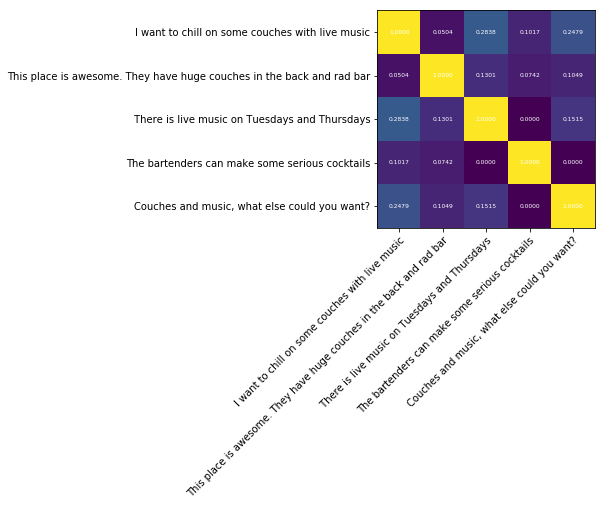

In [27]:
heatmap(test_data,test_data,cosine_similarities)

/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float


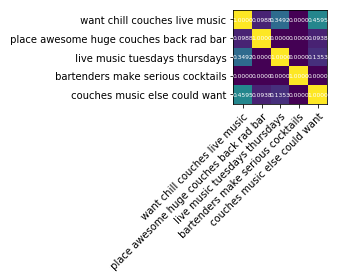

In [28]:
clean_test = []
for t in test_data:
    clean_test.append(cleanup_reviews(t))
tfidfC = TfidfVectorizer().fit_transform(clean_test)
cosine_similarities = linear_kernel(tfidfC, tfidfC).flatten()
cosine_similarities= cosine_similarities.reshape(5,5)
heatmap(clean_test,clean_test,cosine_similarities)

## More exploratory analysis
- business with max similarity
- top 5 businesses with most reviews
- review counts of top 5 businesses
- all stats of top 5 businesses
- top 5 businesses info from bar_df
- top 5 bars selected info

In [151]:
# business with max similarity
variable = results_df.loc[results_df['max_sim']==results_df['max_sim'].max()]
variable

,business_id,cosine_similarities,max_sim,mean_sim,num_reviews
85,Ng-m73-5KMwkMzAPFCS4pw,"[1.0, 0.037893933424878526, 0.2022128843259183...",0.202213,0.053912,7


In [152]:
# top 5 businesses with most reviews
b_id_list = list(results_df.nlargest(5,'num_reviews') ['business_id'])
b_id_list

['SFlAWPKHOJEsTttBLUj8Hw',
 'FJo2jznp56MU_IdDcX038A',
 'DX6G8Vdu9wUx95Tzh6gEwA',
 'cATbxHAuGqdXcmtj5SLA5Q',
 'WEevalqNDxuvOXRG_0EBAA']

In [153]:
# review counts of top 5 businesses
review_count = results_df[results_df['business_id'].isin(b_id_list)]['num_reviews']
review_count

1      51
28     80
76     78
93     33
130    39
Name: num_reviews, dtype: int64

In [154]:
# all stats of top 5 businesses
top_5 = results_df[results_df['business_id'].isin(b_id_list)]
top_5.sort_values('max_sim',ascending=False)

,business_id,cosine_similarities,max_sim,mean_sim,num_reviews
93,WEevalqNDxuvOXRG_0EBAA,"[1.0000000000000002, 0.030428867226862173, 0.0...",0.138012,0.036611,33
28,SFlAWPKHOJEsTttBLUj8Hw,"[1.0000000000000002, 0.03361656362305275, 0.02...",0.127944,0.040106,80
1,DX6G8Vdu9wUx95Tzh6gEwA,"[1.0, 0.03023004341661267, 0.00950739116267452...",0.117004,0.032283,51
76,FJo2jznp56MU_IdDcX038A,"[1.0000000000000002, 0.027253438176760472, 0.0...",0.104254,0.035779,78
130,cATbxHAuGqdXcmtj5SLA5Q,"[1.0000000000000002, 0.014031061252230923, 0.0...",0.099191,0.027384,39


In [155]:
# top 5 businesses info from bar_df
top_5_bars = bars_df[bars_df['business_id'].isin(b_id_list)]
top_5_bars

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,bar
2512,DX6G8Vdu9wUx95Tzh6gEwA,Bartaco Boulder,1048 Pearl St,Boulder,CO,80302,40.017022,-105.282153,4.0,333,1,"{'DriveThru': 'False', 'NoiseLevel': 'u'averag...","Nightlife, Restaurants, Tacos, Mexican, Cockta...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",True
32083,SFlAWPKHOJEsTttBLUj8Hw,Mountain Sun Pub & Brewery,1535 Pearl St,Boulder,CO,80302,40.019011,-105.275215,4.5,1491,1,"{'RestaurantsAttire': ''casual'', 'BYOBCorkage...","Nightlife, Restaurants, Burgers, Bars, Food, B...","{'Monday': '0:0-0:0', 'Tuesday': '12:0-20:0', ...",True
78265,FJo2jznp56MU_IdDcX038A,Avery Brewing,4910 Nautilus Ct N,Boulder,CO,80301,40.062588,-105.204763,4.5,944,1,"{'Smoking': 'u'no'', 'RestaurantsTableService'...","Nightlife, Pubs, American (New), Bars, Restaur...","{'Monday': '0:0-0:0', 'Wednesday': '11:30-20:0...",True
92219,WEevalqNDxuvOXRG_0EBAA,The West End Tavern,926 Pearl St,Boulder,CO,80302,40.017000,-105.283245,4.0,570,1,"{'NoiseLevel': 'u'average'', 'RestaurantsPrice...","Barbeque, American (New), Food, Beer, Wine & S...","{'Monday': '11:30-19:30', 'Tuesday': '11:30-19...",True
127581,cATbxHAuGqdXcmtj5SLA5Q,Roxie's Tacos,"1325 Broadway, Ste 201",Boulder,CO,80203,40.009871,-105.276944,4.5,238,1,"{'Caters': 'True', 'OutdoorSeating': 'True', '...","Latin American, Tacos, Mexican, Food Stands, R...","{'Monday': '0:0-0:0', 'Wednesday': '15:0-22:0'...",True


In [156]:
top_5_df = pd.merge(top_5,top_5_bars)
top_5_df.sort_values('max_sim',ascending=False)

,business_id,cosine_similarities,max_sim,mean_sim,num_reviews,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,bar
3,WEevalqNDxuvOXRG_0EBAA,"[1.0000000000000002, 0.030428867226862173, 0.0...",0.138012,0.036611,33,The West End Tavern,926 Pearl St,Boulder,CO,80302,40.017000,-105.283245,4.0,570,1,"{'NoiseLevel': 'u'average'', 'RestaurantsPrice...","Barbeque, American (New), Food, Beer, Wine & S...","{'Monday': '11:30-19:30', 'Tuesday': '11:30-19...",True
1,SFlAWPKHOJEsTttBLUj8Hw,"[1.0000000000000002, 0.03361656362305275, 0.02...",0.127944,0.040106,80,Mountain Sun Pub & Brewery,1535 Pearl St,Boulder,CO,80302,40.019011,-105.275215,4.5,1491,1,"{'RestaurantsAttire': ''casual'', 'BYOBCorkage...","Nightlife, Restaurants, Burgers, Bars, Food, B...","{'Monday': '0:0-0:0', 'Tuesday': '12:0-20:0', ...",True
0,DX6G8Vdu9wUx95Tzh6gEwA,"[1.0, 0.03023004341661267, 0.00950739116267452...",0.117004,0.032283,51,Bartaco Boulder,1048 Pearl St,Boulder,CO,80302,40.017022,-105.282153,4.0,333,1,"{'DriveThru': 'False', 'NoiseLevel': 'u'averag...","Nightlife, Restaurants, Tacos, Mexican, Cockta...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",True
2,FJo2jznp56MU_IdDcX038A,"[1.0000000000000002, 0.027253438176760472, 0.0...",0.104254,0.035779,78,Avery Brewing,4910 Nautilus Ct N,Boulder,CO,80301,40.062588,-105.204763,4.5,944,1,"{'Smoking': 'u'no'', 'RestaurantsTableService'...","Nightlife, Pubs, American (New), Bars, Restaur...","{'Monday': '0:0-0:0', 'Wednesday': '11:30-20:0...",True
4,cATbxHAuGqdXcmtj5SLA5Q,"[1.0000000000000002, 0.014031061252230923, 0.0...",0.099191,0.027384,39,Roxie's Tacos,"1325 Broadway, Ste 201",Boulder,CO,80203,40.009871,-105.276944,4.5,238,1,"{'Caters': 'True', 'OutdoorSeating': 'True', '...","Latin American, Tacos, Mexican, Food Stands, R...","{'Monday': '0:0-0:0', 'Wednesday': '15:0-22:0'...",True


In [157]:
top_5_bars[['name','address','state','city']]

,name,address,state,city
2512,Bartaco Boulder,1048 Pearl St,CO,Boulder
32083,Mountain Sun Pub & Brewery,1535 Pearl St,CO,Boulder
78265,Avery Brewing,4910 Nautilus Ct N,CO,Boulder
92219,The West End Tavern,926 Pearl St,CO,Boulder
127581,Roxie's Tacos,"1325 Broadway, Ste 201",CO,Boulder


## More exploratory analysis

We already removed any non-matching reviews (kept >0.0001). 

Now we want to see the similarity distribution of all matching reviews so we may possibly set the minimum match higher or have this data available to consider for output to user.
- first example is just the similarties of the reviews matching: Pale ale pool Table swimming pool hoT servers can't the a drank drinking drinks

In [158]:
# remove the 1 in the first position of all similarities and split to list
sim_list = []
temp = top_5_df['cosine_similarities']
l = [i[1:].tolist() for i in temp]
sim_list = [a for b in l for a in b]
sim_list

[0.03023004341661267,
 0.009507391162674524,
 0.013453143502999247,
 0.0430913367940928,
 0.013020904294294994,
 0.025723541038194454,
 0.026006135709445682,
 0.017917038984015032,
 0.012001329196083618,
 0.015528744956534495,
 0.042556176968016,
 0.04145074048262919,
 0.021909192759536473,
 0.028324879737598122,
 0.03445520275068719,
 0.006963061514728974,
 0.057192143339416676,
 0.049307567912709474,
 0.02612418568331756,
 0.02025294494311854,
 0.023982035529192022,
 0.04193918440778987,
 0.03985548771502192,
 0.06471424950384226,
 0.02551685402705264,
 0.01925659370667375,
 0.02329990818660347,
 0.015301678832870936,
 0.10899435056477687,
 0.0480251126241518,
 0.027760816226807927,
 0.014882797303351597,
 0.03080280569401005,
 0.022374435207076968,
 0.06589952934093074,
 0.01557008373695271,
 0.07986015148790598,
 0.03193336126604091,
 0.04943054333461751,
 0.03225763987205683,
 0.032202428634089335,
 0.026831360523056656,
 0.007731365333929742,
 0.02284407087860923,
 0.117003641527

In [136]:
len(sim_list)

206

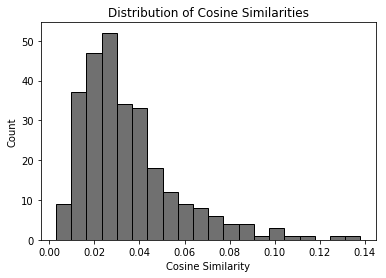

In [159]:
#Plot the distribution plot using seaborn
plt.figure("Test Plots")
sns.histplot(sim_list, label='test_label1', color="0.25")
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.show()

/home/mario/.local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mario/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/mario/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/mario/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: Futur

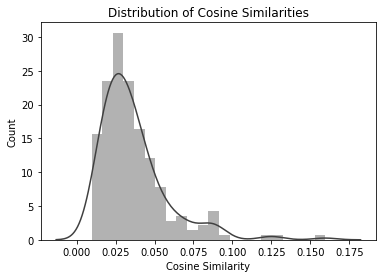

In [138]:
plt.figure("Test Plots")
sns.distplot(sim_list, label='test_label1', color="0.25")
plt.title('Distribution of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.ylabel('Count')
plt.show()

### Distribution of matching means

In [160]:
mean_sims = results_df['mean_sim'].tolist()
mean_sims

[0.03985288635447024,
 0.032282649120136425,
 0.031460778155521944,
 0.04497559583816661,
 0.014611466625601359,
 0.04283625320481107,
 0.05317429459220656,
 0.056275560200241014,
 0.08321221403219754,
 0.04369378265729941,
 0.09084434137407622,
 0.03066035964101353,
 0.049643147107003134,
 0.03209734494918276,
 0.041091066367427806,
 0.03144820202280303,
 0.038158220244057406,
 0.030199853335201282,
 0.04848582791342525,
 0.04801264593098941,
 0.03451291833423051,
 0.03308120269754966,
 0.026465928236092003,
 0.03552271624650667,
 0.02022067048385183,
 0.016805496560696718,
 0.03786089446072905,
 0.021723935148279198,
 0.04010607705176385,
 0.03268429515002563,
 0.04760690698484113,
 0.011668610847682842,
 0.047763501549572124,
 0.04011419556829734,
 0.020769262131566754,
 0.04882535179597514,
 0.02681823511866985,
 0.04198158007065804,
 0.06398902848220352,
 0.037440722947398565,
 0.061838698381323526,
 0.035681114087722315,
 0.029951101294921356,
 0.02611860665436001,
 0.01576442718

/home/mario/.local/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mario/.local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1377: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/mario/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:237: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/mario/.local/lib/python3.7/site-packages/matplotlib/axes/_base.py:239: Futur

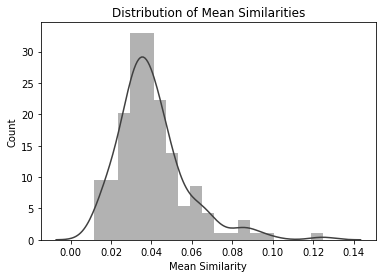

In [161]:
plt.figure("Test Plots")
sns.distplot(mean_sims, label='test_label1', color="0.25")
plt.title('Distribution of Mean Similarities')
plt.xlabel('Mean Similarity')
plt.ylabel('Count')
plt.show()

## More exploratory analysis

In [162]:
# reindex in descending order
top = top_5_df.sort_values('max_sim',ascending=False)
top.reset_index(drop=True, inplace = True)
top

,business_id,cosine_similarities,max_sim,mean_sim,num_reviews,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,bar
0,WEevalqNDxuvOXRG_0EBAA,"[1.0000000000000002, 0.030428867226862173, 0.0...",0.138012,0.036611,33,The West End Tavern,926 Pearl St,Boulder,CO,80302,40.017000,-105.283245,4.0,570,1,"{'NoiseLevel': 'u'average'', 'RestaurantsPrice...","Barbeque, American (New), Food, Beer, Wine & S...","{'Monday': '11:30-19:30', 'Tuesday': '11:30-19...",True
1,SFlAWPKHOJEsTttBLUj8Hw,"[1.0000000000000002, 0.03361656362305275, 0.02...",0.127944,0.040106,80,Mountain Sun Pub & Brewery,1535 Pearl St,Boulder,CO,80302,40.019011,-105.275215,4.5,1491,1,"{'RestaurantsAttire': ''casual'', 'BYOBCorkage...","Nightlife, Restaurants, Burgers, Bars, Food, B...","{'Monday': '0:0-0:0', 'Tuesday': '12:0-20:0', ...",True
2,DX6G8Vdu9wUx95Tzh6gEwA,"[1.0, 0.03023004341661267, 0.00950739116267452...",0.117004,0.032283,51,Bartaco Boulder,1048 Pearl St,Boulder,CO,80302,40.017022,-105.282153,4.0,333,1,"{'DriveThru': 'False', 'NoiseLevel': 'u'averag...","Nightlife, Restaurants, Tacos, Mexican, Cockta...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",True
3,FJo2jznp56MU_IdDcX038A,"[1.0000000000000002, 0.027253438176760472, 0.0...",0.104254,0.035779,78,Avery Brewing,4910 Nautilus Ct N,Boulder,CO,80301,40.062588,-105.204763,4.5,944,1,"{'Smoking': 'u'no'', 'RestaurantsTableService'...","Nightlife, Pubs, American (New), Bars, Restaur...","{'Monday': '0:0-0:0', 'Wednesday': '11:30-20:0...",True
4,cATbxHAuGqdXcmtj5SLA5Q,"[1.0000000000000002, 0.014031061252230923, 0.0...",0.099191,0.027384,39,Roxie's Tacos,"1325 Broadway, Ste 201",Boulder,CO,80203,40.009871,-105.276944,4.5,238,1,"{'Caters': 'True', 'OutdoorSeating': 'True', '...","Latin American, Tacos, Mexican, Food Stands, R...","{'Monday': '0:0-0:0', 'Wednesday': '15:0-22:0'...",True


In [163]:
top5_bids = top['business_id'].tolist()
top5_bids

['WEevalqNDxuvOXRG_0EBAA',
 'SFlAWPKHOJEsTttBLUj8Hw',
 'DX6G8Vdu9wUx95Tzh6gEwA',
 'FJo2jznp56MU_IdDcX038A',
 'cATbxHAuGqdXcmtj5SLA5Q']

## Create wordcloud of all reviews for the top five businesses

Decided to create another function based on the original function filter_score, but this one spits out the review_list rather than the cosine similarities.

In [121]:
grouped_reviews_by_business = review_business_df.groupby('business_id')

#pass in the grouped by object, business ID of interest and the user input
def filter_score2(grouped_reviews, business_ID,user_experience):
    temp = grouped_reviews.get_group(str(business_ID))
    review_list = [user_experience]
    #itterate through the review text, clean it and apppend the cleaned text to the temp list
    for t in temp['text']:
        review_list.append(cleanup_reviews(t))
    #vecotrize the temp list and calculate the cosine similarity
    tfidf = TfidfVectorizer().fit_transform(review_list)
    cosine_similarities = linear_kernel(tfidf[0:1], tfidf).flatten()
    index = np.argwhere(cosine_similarities<0.0001)
    review_list = np.delete(review_list, index)
    return(review_list)

In [164]:
top5_rev_list = []

for b in top5_bids:
    try:
        review_list5 = filter_score2(grouped_reviews_by_business,b,word_descriptors_clean)
        # get rid of user_experience a
        top5_rev_list.append(review_list5[1:].tolist())
    except:
        pass
    
top5_rev_list[0]

/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/metrics/pairwise.py:54: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype = np.float
/home/mario/.local/lib/python3.7/site-packages/sklearn/m

['like authentic boulder local real deal place lack authentic service server young woman talk look social skill abandon learn kid job meet public make money fun nice friendly people especially customer',
 'rainy day boulder need somewhere aps meal place hit spot burn end delicious barbecue sauce so tasty brisket sandwich great skip bean definitely need time cook bite mkre flavor fry good pickle sandwich delightful onion soup great better yet waiter give u sample soup order ask question taste pink lemonade tasty good selection drink josh waiter stellar look like roof deck pretty sweet nice day would excite check',
 'burn end amaze pricey much get whiskey ky selection awesome especially bourbon outdoor patio great weather cold chicken hot link nice juicy overall price food quality excellent good spot brunch happy hour',
 'perfect place friday night fill burger beer always leave fat happy love place however place go look light dinner',
 'go west end tavern week ago dream ever since bq pla

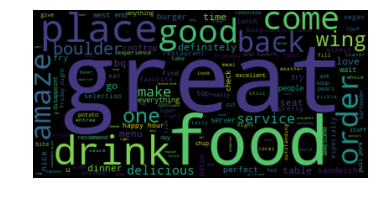

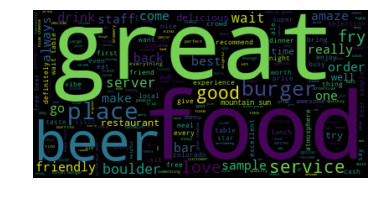

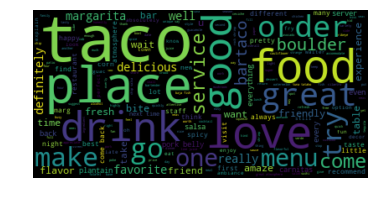

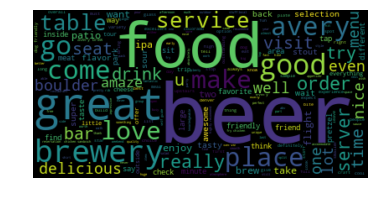

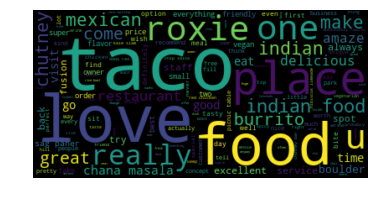

In [165]:
%matplotlib inline
for i in top5_rev_list:
    wordcloud = WordCloud().generate(' '.join(map(str,i)))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis("off")
    plt.show()
        

From our initial cleaned user_experience input (pale ale love pool table swim pool hot server drink stuff) we see 'service', 'beer' and 'drink' show up. This really brings up a point about needing to consider bigrams and sentiment. For example 'service shows up in all 5 to varying degrees, but was it 'good service'. Our initial thought was that tfidf vectorization would consider these. Given more time we would definitely add these considerations. 

## Map of top five

In [166]:
# sort by max_sim
top = top_5_df.sort_values('max_sim',ascending=False)
top.reset_index(drop=True, inplace = True)
top

,business_id,cosine_similarities,max_sim,mean_sim,num_reviews,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,bar
0,WEevalqNDxuvOXRG_0EBAA,"[1.0000000000000002, 0.030428867226862173, 0.0...",0.138012,0.036611,33,The West End Tavern,926 Pearl St,Boulder,CO,80302,40.017000,-105.283245,4.0,570,1,"{'NoiseLevel': 'u'average'', 'RestaurantsPrice...","Barbeque, American (New), Food, Beer, Wine & S...","{'Monday': '11:30-19:30', 'Tuesday': '11:30-19...",True
1,SFlAWPKHOJEsTttBLUj8Hw,"[1.0000000000000002, 0.03361656362305275, 0.02...",0.127944,0.040106,80,Mountain Sun Pub & Brewery,1535 Pearl St,Boulder,CO,80302,40.019011,-105.275215,4.5,1491,1,"{'RestaurantsAttire': ''casual'', 'BYOBCorkage...","Nightlife, Restaurants, Burgers, Bars, Food, B...","{'Monday': '0:0-0:0', 'Tuesday': '12:0-20:0', ...",True
2,DX6G8Vdu9wUx95Tzh6gEwA,"[1.0, 0.03023004341661267, 0.00950739116267452...",0.117004,0.032283,51,Bartaco Boulder,1048 Pearl St,Boulder,CO,80302,40.017022,-105.282153,4.0,333,1,"{'DriveThru': 'False', 'NoiseLevel': 'u'averag...","Nightlife, Restaurants, Tacos, Mexican, Cockta...","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:0', ...",True
3,FJo2jznp56MU_IdDcX038A,"[1.0000000000000002, 0.027253438176760472, 0.0...",0.104254,0.035779,78,Avery Brewing,4910 Nautilus Ct N,Boulder,CO,80301,40.062588,-105.204763,4.5,944,1,"{'Smoking': 'u'no'', 'RestaurantsTableService'...","Nightlife, Pubs, American (New), Bars, Restaur...","{'Monday': '0:0-0:0', 'Wednesday': '11:30-20:0...",True
4,cATbxHAuGqdXcmtj5SLA5Q,"[1.0000000000000002, 0.014031061252230923, 0.0...",0.099191,0.027384,39,Roxie's Tacos,"1325 Broadway, Ste 201",Boulder,CO,80203,40.009871,-105.276944,4.5,238,1,"{'Caters': 'True', 'OutdoorSeating': 'True', '...","Latin American, Tacos, Mexican, Food Stands, R...","{'Monday': '0:0-0:0', 'Wednesday': '15:0-22:0'...",True


In [167]:

lat = top['latitude'].loc[0]
lon = top['longitude'].loc[0]
lat, lon

(40.0170001, -105.2832453)

In [168]:
coords = top[['latitude','longitude']]
coords = coords.to_records(index=False)
coords

rec.array([(40.0170001 , -105.2832453 ), (40.0190106 , -105.2752151 ),
           (40.01702193, -105.28215301), (40.0625885 , -105.2047632 ),
           (40.009871  , -105.276944  )],
          dtype=[('latitude', '<f8'), ('longitude', '<f8')])

In [169]:
m = folium.Map(
    location=coords[0], zoom_start=13)
tooltip = top['name'].loc[0] + ' Number 1 choice'
for i in range(5):
    tooltip = top['name'].loc[i] + f" Your number {i+1} choice"
    folium.Marker(        
        coords[i],tooltip=tooltip).add_to(m)
m

In the future we would consider user input for proximity, as in how far they are willing to travel.